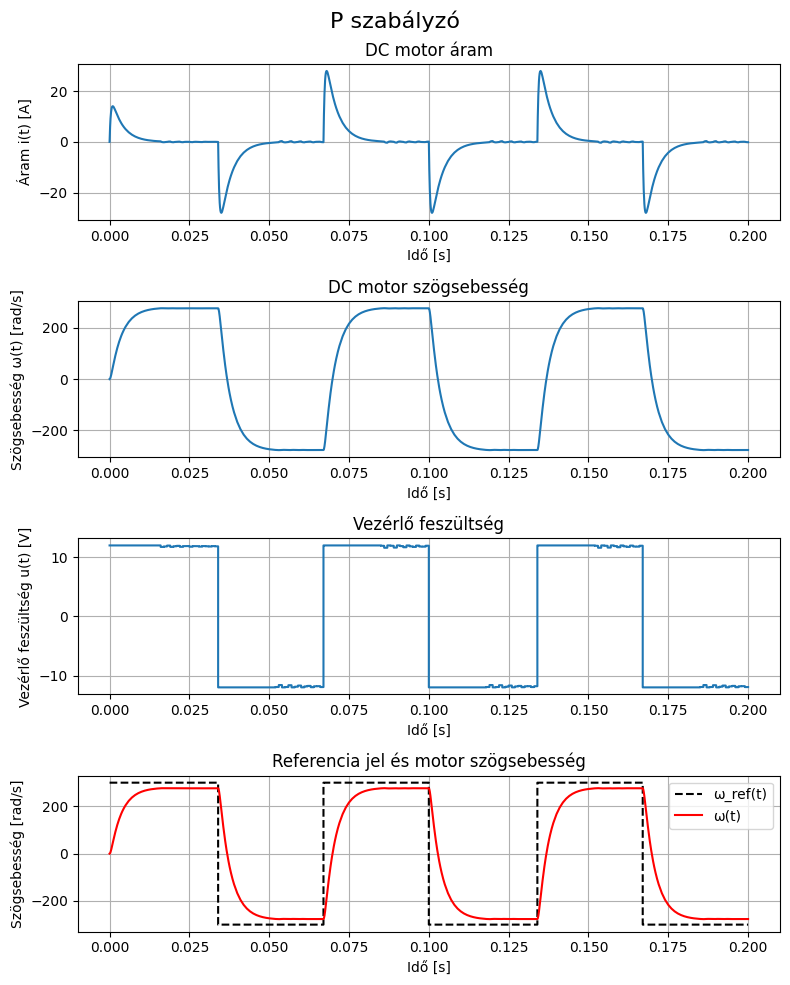

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Motor paraméterek és a vezérléshez szükséges állandók
R      = 0.716      # Armatúra ellenállás [ohm]
L      = 0.00026    # Armatúra induktivitás [H]
k      = 0.0429     # Motor állandó (Nm/A vagy V/(rad/s))
J      = 1e-5       # Tehetetlenségi nyomaték [kg*m^2]
b      = 0.0        # Viszkózus súrlódás [N*m*s/rad]
T_load = 0.0        # Terhelő nyomaték [Nm]

# Szabályozó paraméterek
Kp     = 0.5       # P-szabályozó erősítés
Vmax   = 12.0      # Feszültség szaturáció (±V)

# Referencia jel (négyszögjel) paraméterek
w_high = 300      # Felső szögsebesség [rad/s]
w_low  = -300     # Alsó szögsebesség [rad/s]
freq   = 15       # Négyszögjel frekvencia [Hz]
T_period = 1 / freq

# Szimulációs beállítások
t_max         = 0.2     # Szimulációs idő [s]
dt_controller = 1e-3    # Szabályozó frissítési időköze [s]

# Inicializáció
x = np.array([0.0, 0.0])  # Kezdeti állapot: [áram, szögsebesség]
t_current = 0.0         # Kezdeti idő

# Eredmények tárolása
T_all     = []
I_all     = []
Omega_all = []
U_all     = []
Wref_all  = []

# Szimuláció: vezérlő update + motor integrálás adaptív lépésközzel
while t_current < t_max:
    # Következő vezérlő update időpontja
    t_next = min(t_current + dt_controller, t_max)
    
    # Referencia jel számítása (négyszögjel)
    if (t_current % T_period) < (T_period / 2):
        w_ref = w_high
    else:
        w_ref = w_low
        
    # Hibaszámítás és vezérlő kimenet számítása
    error = w_ref - x[1]  # x[1] a motor szögsebessége (omega)
    u_raw = Kp * error
    u = max(-Vmax, min(u_raw, Vmax))  # Szaturáció
    
    # Motor dinamikájának integrációja az adott intervallumban
    def motor_ode(t, x):
        di_dt = (u - R*x[0] - k*x[1]) / L
        domega_dt = (k*x[0] - b*x[1] - T_load) / J
        return [di_dt, domega_dt]
    
    # Opciók az integrátorhoz (használható a pontosság növeléséhez)
    opts = {'rtol': 1e-6, 'atol': 1e-9}
    sol = solve_ivp(motor_ode, (t_current, t_next), x, method='RK45', **opts)
    
    # Eredmények tárolása
    T_all.extend(sol.t)
    I_all.extend(sol.y[0])
    Omega_all.extend(sol.y[1])
    U_all.extend(u * np.ones_like(sol.t))
    Wref_all.extend(w_ref * np.ones_like(sol.t))
    
    # Kezdőállapot frissítése a következő intervallumhoz
    x = sol.y[:, -1]
    t_current = t_next

# Ábrázolás
plt.figure(figsize=(8, 10))
# Főcím elhelyezése a teljes ábra fölött, de nem fedve az alsóbb címeket
plt.suptitle('P szabályzó', fontsize=16, y=0.98)

plt.subplot(4, 1, 1)
plt.plot(T_all, I_all, linewidth=1.5)
plt.xlabel('Idő [s]')
plt.ylabel('Áram i(t) [A]')
plt.title('DC motor áram')
plt.grid(True)

plt.subplot(4, 1, 2)
plt.plot(T_all, Omega_all, linewidth=1.5)
plt.xlabel('Idő [s]')
plt.ylabel('Szögsebesség ω(t) [rad/s]')
plt.title('DC motor szögsebesség')
plt.grid(True)

plt.subplot(4, 1, 3)
plt.plot(T_all, U_all, linewidth=1.5)
plt.xlabel('Idő [s]')
plt.ylabel('Vezérlő feszültség u(t) [V]')
plt.title('Vezérlő feszültség')
plt.grid(True)

plt.subplot(4, 1, 4)
plt.plot(T_all, Wref_all, 'k--', linewidth=1.5, label='ω_ref(t)')
plt.plot(T_all, Omega_all, 'r', linewidth=1.5, label='ω(t)')
plt.xlabel('Idő [s]')
plt.ylabel('Szögsebesség [rad/s]')
plt.title('Referencia jel és motor szögsebesség')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


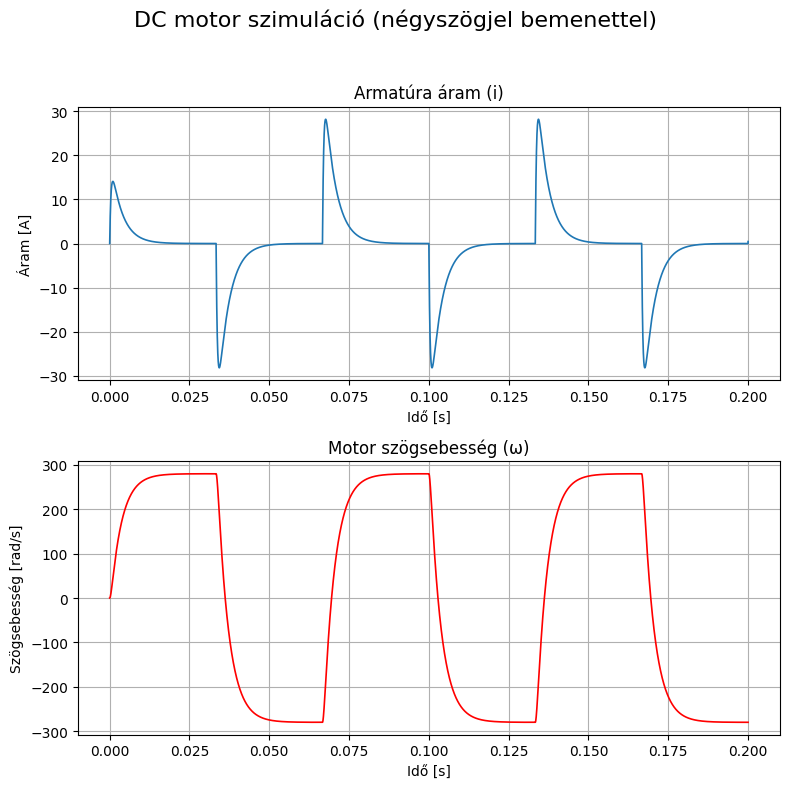

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import StateSpace, lsim, square

# --- Motor paraméterek ---
R = 0.716         # Armatúra ellenállás [Ohm]
L = 0.00026       # Armatúra induktivitás [H]
k = 0.0429        # Motor állandó [Nm/A vagy V/(rad/s)]
J = 1e-5          # Tehetetlenségi nyomaték [kg·m^2]
b = 0             # Viszkózus súrlódás [N·m·s/rad] (jelen esetben 0)

# --- Állapottér modell ---
# Egyenletek:
#   L * di/dt      = u - R*i - k*omega    -> di/dt = (1/L)*u - (R/L)*i - (k/L)*omega
#   J * d(omega)/dt= k*i - b*omega          -> d(omega)/dt = (k/J)*i - (b/J)*omega
#
# Mátrix alakban:
A = np.array([[-R/L, -k/L],
              [ k/J, -b/J]])
B = np.array([[1/L],
              [0]])
C = np.eye(2)   # Figyeljük mindkét állapotot: i(t) és omega(t)
D = np.array([[0],
              [0]])

# --- Szimuláció beállításai ---
t_max = 0.2           # Szimulációs idő [s]
dt    = 1e-5          # Időlépés
t = np.arange(0, t_max+dt, dt)  # idővektor (a végpont is szerepel)

# Négyszögjel bemenet beállítása: 12 V amplitúdó, 15 Hz frekvencia
freq = 15             # frekvencia [Hz]
u = 12 * square(2 * np.pi * freq * t)  # A square függvény értéke -1 és 1 között váltakozik

x0 = np.array([0, 0])     # Kezdeti feltételek: i(0)=0, omega(0)=0

# --- Rendszer létrehozása és szimuláció ---
sys = StateSpace(A, B, C, D)
# lsim szimulálja a rendszer válaszát a bemenetre, a kezdőállapotra
t_out, y, x_out = lsim(sys, U=u, T=t, X0=x0)

# --- Eredmények ábrázolása ---
plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 1)
plt.plot(t_out, y[:, 0], linewidth=1.2)
plt.grid(True)
plt.xlabel('Idő [s]')
plt.ylabel('Áram [A]')
plt.title('Armatúra áram (i)')

plt.subplot(2, 1, 2)
plt.plot(t_out, y[:, 1], 'r', linewidth=1.2)
plt.grid(True)
plt.xlabel('Idő [s]')
plt.ylabel('Szögsebesség [rad/s]')
plt.title('Motor szögsebesség (ω)')

plt.suptitle('DC motor szimuláció (négyszögjel bemenettel)', 
             fontsize=16, y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


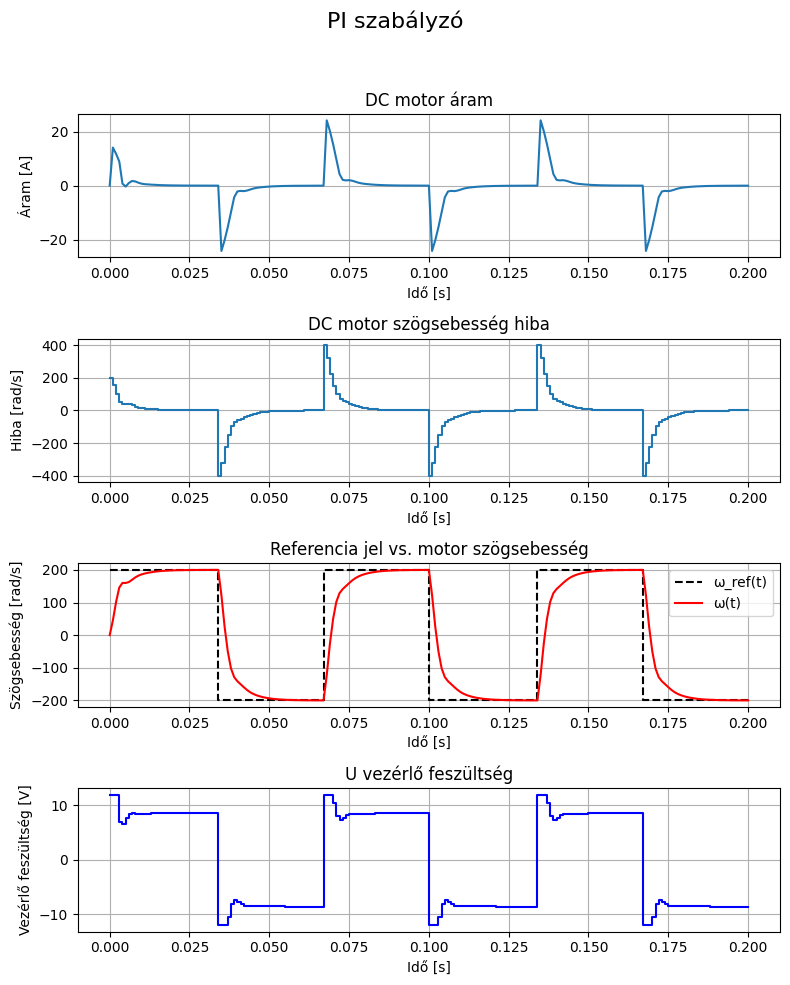

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

def motor_ode(t, x, u, R, L, k, J, b, T_load):
    """
    DC motor differenciálegyenletei:
      x[0] = i      (áram)
      x[1] = omega  (szögsebesség)
    """
    di_dt = (u - R*x[0] - k*x[1]) / L
    domega_dt = (k*x[0] - b*x[1] - T_load) / J
    return [di_dt, domega_dt]

# Paraméterek
R      = 0.716     # Armatúra ellenállás [ohm]
L      = 0.00026   # Armatúra induktivitás [H]
k      = 0.0429    # Motor állandó
J      = 1e-5      # Tehetetlenségi nyomaték [kg*m^2]
b      = 0.0       # Viszkózus súrlódás
T_load = 0.0       # Terhelő nyomaték [Nm]

# PI szabályozó paraméterek
Kp     = 0.1       # Arányos erősítés
Ki     = 275       # Integrális erősítés
Vmax   = 12.0      # Feszültség szaturáció (±V)

# Referencia jel paraméterek (négyszögjel)
w_high = 200       # Felső szögsebesség [rad/s]
w_low  = -200      # Alsó szögsebesség [rad/s]
freq   = 15        # Négyszögjel frekvencia [Hz]

# Szimulációs beállítások
t_max         = 0.2      # Szimulációs idő [s]
dt_controller = 1e-3     # Controller frissítési időköz [s]

# Inicializáció
state = np.array([0.0, 0.0])  # kezdeti állapot: [i, omega]
e_int = 0.0                 # kezdeti integrált hiba
t_current = 0.0             # aktuális idő

# Eredmények tárolása
T_all     = []
I_all     = []
Omega_all = []
U_all     = []
Wref_all  = []
error_all = []
error_int_all = []

# Szimuláció controller intervallumokban
while t_current < t_max:
    # Referencia négyszögjel számítása
    T_period = 1 / freq
    if (t_current % T_period) < (T_period / 2):
        w_ref = w_high
    else:
        w_ref = w_low

    # Hibaszámítás: referencia - aktuális szögsebesség
    error_val = w_ref - state[1]

    # PI szabályozó számítása:
    # u = Kp * (error + Ki * dt_controller*(integrált hiba + mostani hiba))
    u = Kp * (error_val + Ki * dt_controller * (e_int + error_val))
    
    # Szaturáció
    int_flag = True
    if u > Vmax:
        u = Vmax
        int_flag = False  # integráló tag fagyasztása telítés esetén
    elif u < -Vmax:
        u = -Vmax
        int_flag = False

    if int_flag:
        e_int += error_val

    # Következő controller intervallum vége
    t_interval_end = min(t_current + dt_controller, t_max)
    t_span = (t_current, t_interval_end)
    
    # Motor dinamikájának integrációja (solve_ivp – adaptív lépésköz)
    sol = solve_ivp(
        lambda t, x: motor_ode(t, x, u, R, L, k, J, b, T_load),
        t_span,
        state,
        method='RK45',
        t_eval=np.linspace(t_current, t_interval_end, 2)
    )
    
    # Eredmények tárolása
    T_all.extend(sol.t)
    I_all.extend(sol.y[0])
    Omega_all.extend(sol.y[1])
    U_all.extend([u] * len(sol.t))
    Wref_all.extend([w_ref] * len(sol.t))
    error_all.extend([error_val] * len(sol.t))
    error_int_all.extend([e_int] * len(sol.t))
    
    # Állapot frissítése (utolsó integrációs pont)
    state = sol.y[:, -1]
    
    # Idő frissítése
    t_current = t_interval_end

# Ábrázolás
plt.figure(figsize=(8, 10))
# Főcím elhelyezése a teljes ábra fölött, de nem fedve az alsóbb címeket
plt.suptitle('PI szabályzó', fontsize=16, y=0.98)

plt.subplot(4, 1, 1)
plt.plot(T_all, I_all, linewidth=1.5)
plt.xlabel('Idő [s]')
plt.ylabel('Áram [A]')
plt.title('DC motor áram')
plt.grid()

plt.subplot(4, 1, 2)
plt.plot(T_all, error_all, linewidth=1.5)
plt.xlabel('Idő [s]')
plt.ylabel('Hiba [rad/s]')
plt.title('DC motor szögsebesség hiba')
plt.grid()

plt.subplot(4, 1, 3)
plt.plot(T_all, Wref_all, 'k--', linewidth=1.5, label='ω_ref(t)')
plt.plot(T_all, Omega_all, 'r', linewidth=1.5, label='ω(t)')
plt.xlabel('Idő [s]')
plt.ylabel('Szögsebesség [rad/s]')
plt.title('Referencia jel vs. motor szögsebesség')
plt.legend()
plt.grid()

plt.subplot(4, 1, 4)
plt.plot(T_all, U_all, 'b', linewidth=1.5)
plt.xlabel('Idő [s]')
plt.ylabel('Vezérlő feszültség [V]')
plt.title('U vezérlő feszültség')
plt.grid()

# tight_layout beállítása, hogy a főcímnek is legyen helye
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
